In [11]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan  3 11:25:49 2024

@author: OptiRotor
"""
import os
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
#suppress tensorflow warning

# The airfoil coordinates are stored on this website: https://m-selig.ae.illinois.edu/ads/coord_seligFmt/

# Load data with pandas
data_pd = pd.read_pickle(r"data/combinedAirfoilDataLabeled_mod_CST.pkl")   #version with CST parametrization
print(data_pd.head())
print(data_pd.info())
print(data_pd.describe())
print(data_pd.columns)

  airfoilName  kulfan_coeff_0  kulfan_coeff_1  kulfan_coeff_2  kulfan_coeff_3  \
0       2032c         1.70078       -0.458245        0.180092        0.625842   
1       2032c         1.70078       -0.458245        0.180092        0.625842   
2       2032c         1.70078       -0.458245        0.180092        0.625842   
3       2032c         1.70078       -0.458245        0.180092        0.625842   
4       2032c         1.70078       -0.458245        0.180092        0.625842   

   kulfan_coeff_4  kulfan_coeff_5  kulfan_coeff_6  kulfan_coeff_7  \
0        0.396842        0.310471        1.054395       -0.451307   
1        0.396842        0.310471        1.054395       -0.451307   
2        0.396842        0.310471        1.054395       -0.451307   
3        0.396842        0.310471        1.054395       -0.451307   
4        0.396842        0.310471        1.054395       -0.451307   

   kulfan_coeff_8  ...  kulfan_coeff_26  kulfan_coeff_27  reynoldsNumber  \
0         1.27906  ...

# Preprocessing
1. Delete airfoils with unphysical transition location
2. Shuffle data
3. Remove column "airfoilName" from dataset
4. Split dataset in features x and labels y
5. Split data in train and test data
6. Scale data

In [2]:
# drop airfoilnames with unphysical location of transition
delete_airfoil_name = data_pd[data_pd["topXTR"]>1.1]["airfoilName"].unique()
# delete airfoils in data_pd
data = data_pd.loc[~data_pd['airfoilName'].isin(delete_airfoil_name)]    #~ means "is not in" in delete_airfoil_name

# # reduce amount of data for fast early set-up #ATTENTION
# data = data.iloc[:10000,:]
#shuffle data
data = data.sample(frac=1, random_state=42)

# get all airfoil names 
names_all = data["airfoilName"]
names_unique = names_all.unique()

# drop airfoilname from data. It is not needed any more
data = data.drop(columns=["airfoilName"])

# Daten in ein NumPy-Array umwandeln
data = data.to_numpy()
data = data.astype('float32')

## Split data in features x and labels y
# number of features and labels
num_features = 30    
num_labels = 6

x = data[:,0:num_features]
y = data[:,num_features:]


#split such as complete airfoil is in either training oder test dataset
names_train, names_test = train_test_split(
    names_unique, test_size=0.2, random_state=42)

id_train = np.isin(names_all, names_train)
id_test = np.isin(names_all, names_test)

x_train = x[id_train]
y_train = y[id_train]
x_test = x[id_test]
y_test = y[id_test]


# Sacle all data using MinMax-Scaler
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Machine Learning Setup


In [12]:
# Score-function
# Define 2 types of score functions

def r2_score(y_true, y_pred):
    '''
    Classic r2 score
    '''
    y_diff = tf.reduce_sum(tf.square(y_true-y_pred))
    y_square = tf.reduce_sum(tf.square(y_true-tf.reduce_mean(y_true)))
    return 1-y_diff/y_square

def r2_score_separated(y_true, y_pred):
    '''
    Classic r2 score. But the score is evaluated for each predicted variable (label) separately i.e R2_Lift, R2_Drag
    '''
    y_diff = tf.reduce_sum(tf.square(y_true-y_pred), axis=0)
    y_square = tf.reduce_sum(tf.square(y_true-tf.reduce_mean(y_true)), axis=0)
    return 1-y_diff/y_square


lr = 0.0005

# A folder for log files must be created for Tensorboard
root_logdir = os.path.join(os.curdir, "my_logs")

# A subfolder of the current day and time is created for each run
# '/my_logs/run_2019_06_07-15_15_22'
run_id = time.strftime("lr="+str(lr)+"_Adam_%Y_%m_%d-%H_%M_%S")
run_logdir = os.path.join(root_logdir, run_id)

# Callback for the Tensorboard
# run_logdir is the path where the log files are saved
tensorboard = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1)

# To execute the tensor board after the fit process has been run:
# in anaconda prompt:
# change to current directory with: cd (pfad)
# tensorboard --logdir=./my_logs --port=6006
# Subsequently in browser: http://localhost:6006

# the learning rate can be reduced when a plateau of the loss value is reached
# This sometimes allows the optimization to reach the minimum better and achieve
# a lower loss value, especially with regression
lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=20,
    verbose=0,
    mode="auto",
    min_delta=0.0,
    cooldown=0,
    min_lr=1e-6)

#### Setup of the NN model
# dropout rate
dr = 0.2 # switched off as model doesn't tend to overfit
tf.random.set_seed(42)

#following steps:
    # 1. change from relu to leaky_relu --> helped a lot
    # 2. from kernel_initializer="GlorotUniform" to "he_normal" brings minimal advantages
    # 3. try batchnormalization --> probably only helps with deep networks

#Sequential method
model = keras.models.Sequential()
model.add(keras.Input(shape=(num_features,)))
model.add(keras.layers.Dense(100, activation='leaky_relu', kernel_initializer="he_normal"))
#model.add(keras.layers.BatchNormalization())   # --> was not key for improvement
# maybe try "leaky_relu" --> was success
model.add(keras.layers.Dropout(dr))
model.add(keras.layers.Dense(200, activation='leaky_relu', kernel_initializer="he_normal"))
#model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Dense(300, activation='relu'))
# model.add(keras.layers.Dense(400, activation='relu'))
# model.add(keras.layers.Dense(300, activation='relu'))
# model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dropout(dr))
model.add(keras.layers.Dense(100, activation='leaky_relu', kernel_initializer="he_normal"))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(num_labels))


# Optimizer with specific Lernrate
opt = keras.optimizers.Adam(learning_rate=lr)    #[0.001, 0.01, 0.02] best: 0.001

# Assign loss function, optimizer and metric to the neural network
model.compile(loss='mse',
              optimizer=opt, 
              metrics=[r2_score],
              # loss_weights=weights, #ATTENTION
              )

# Show summary of model
model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               3100      
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 6)                 606       
                                                                 
Total params: 44006 (171.90 KB)
Trainable params: 4400

# Training

In [13]:
## train the model
history = model.fit(x_train, y_train, batch_size=15,    #[15, 50] best: 15; default: 50
                    epochs=200,     #200 Epochs
                    validation_data=(x_test, y_test),
                    callbacks=[lr_reduction, tensorboard]
                    ) 



42705/42705 [==============================] - 97s 2ms/step - loss: 0.0115 - r2_score: 0.9023 - val_loss: 0.0081 - val_r2_score: 0.9311 - lr: 5.0000e-04


In [15]:
## Save the model in order to use it later for further things
# model.save("model_3layers.keras")
## Load a pretrained model
#model = keras.models.load_model('model_3layers.keras', custom_objects={"r2_score": r2_score})

In [6]:
# Score evaluation after training
# Training Score separated for each output label
y_pred = model.predict(x_train)
score_train = r2_score_separated(y_train, y_pred).numpy()
print("R2-Score Train \n\
      C_Lift= %.5f \n\
      C_Drag= %.5f \n\
      C_parasite_Drag= %.5f \n\
      C_m= %.5f \n\
      X_tr_top= %.5f \n\
      X_tr_bot= %.5f \n\
      " %(score_train[0], score_train[1], score_train[2], score_train[3], score_train[4], score_train[5]))
# Test Score
y_pred = model.predict(x_test)
score_test = r2_score_separated(y_test, y_pred).numpy()
print("R2-Score Test \n\
      C_Lift= %.5f \n\
      C_Drag= %.5f \n\
      C_parasite_Drag= %.5f \n\
      C_m= %.5f \n\
      X_tr_top= %.5f \n\
      X_tr_bot= %.5f \n\
      " %(score_test[0], score_test[1], score_test[2], score_test[3], score_test[4], score_test[5]))

20018/20018 [==============================] - 19s 928us/step
R2-Score Train 
      C_Lift= 0.96313 
      C_Drag= 0.99204 
      C_parasite_Drag= 0.99183 
      C_m= 0.92472 
      X_tr_top= 0.91395 
      X_tr_bot= 0.86434 
      
5024/5024 [==============================] - 5s 940us/step
R2-Score Test 
      C_Lift= 0.96123 
      C_Drag= 0.99148 
      C_parasite_Drag= 0.99140 
      C_m= 0.92121 
      X_tr_top= 0.91509 
      X_tr_bot= 0.86238 
      


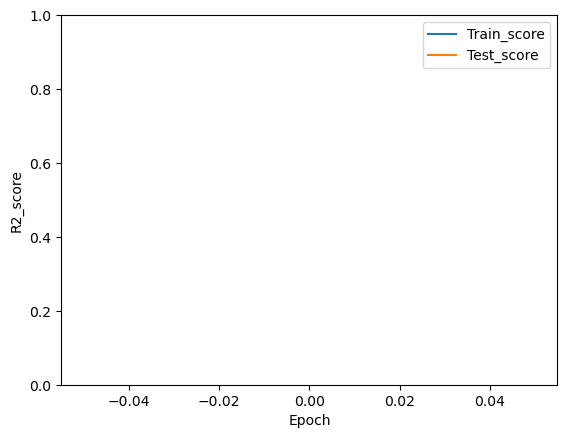

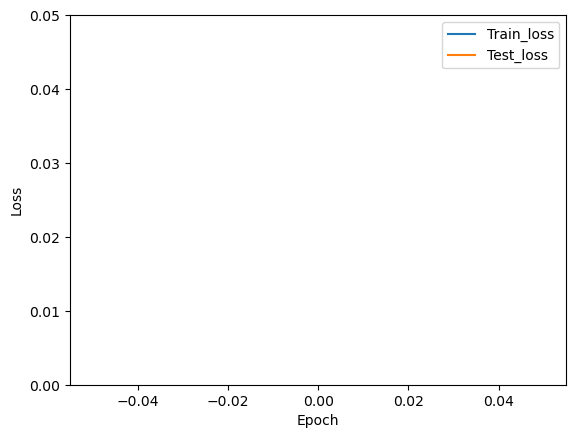

In [7]:
# Plot the learning curves
plt.plot(history.history['r2_score'], label='Train_score')
plt.plot(history.history['val_r2_score'], label='Test_score')
plt.xlabel('Epoch')
plt.ylabel('R2_score')
plt.ylim(0,1)
plt.legend()
plt.show()
# Plot loss
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,0.05)
plt.legend()
plt.show()

# Plot airfoil coefficients from database

The arbitrary airfoil name for visualization of the results is: mh32


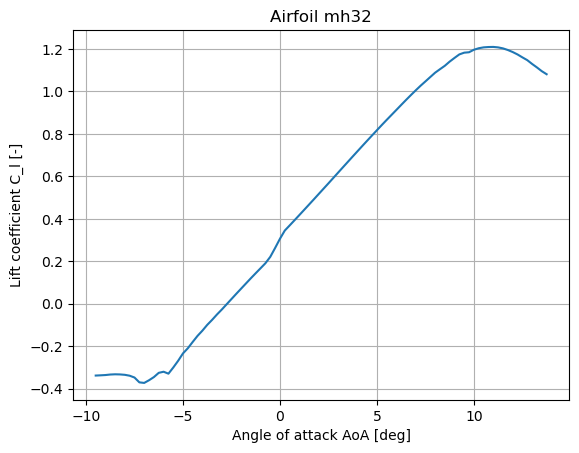

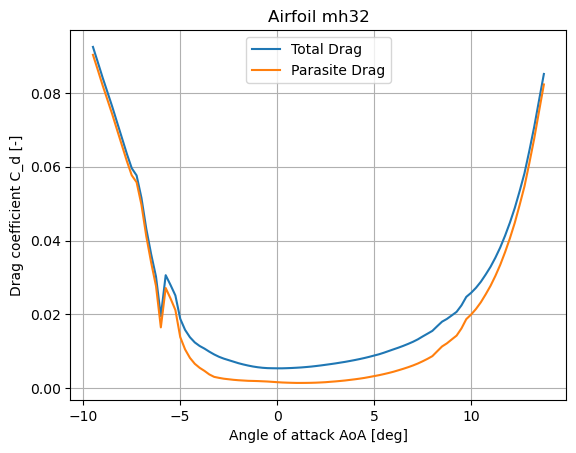

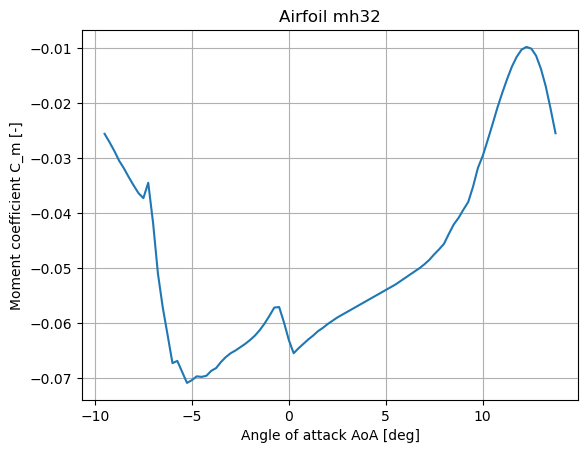

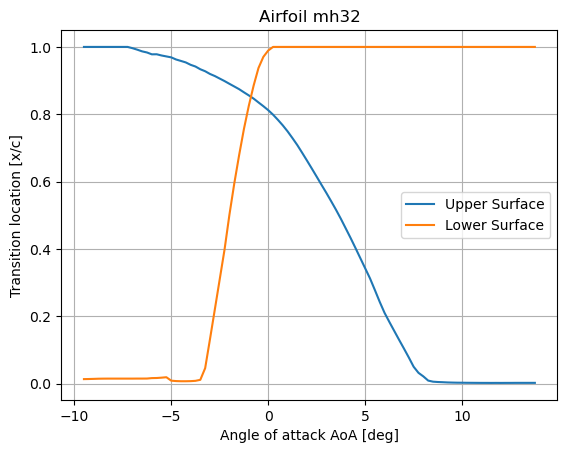

In [16]:
#take arbitrary airfoil from test data
airfoilname = names_test[1]
print("The arbitrary airfoil name for visualization of the results is: %s" %(airfoilname))

Re = 500000

idx_airfoil = data_pd["airfoilName"]==airfoilname
idx_Re = data_pd["reynoldsNumber"]==Re
idx = np.logical_and(idx_airfoil, idx_Re)

alpha = data_pd[idx]["alpha"]
c_l = data_pd[idx]["coefficientLift"]
c_d = data_pd[idx]["coefficientDrag"]
c_d_par = data_pd[idx]["coefficientParasiteDrag"]
c_m = data_pd[idx]["coefficientMoment"]
x_tr_t = data_pd[idx]["topXTR"]
x_tr_b = data_pd[idx]["botXTR"]

title = "Airfoil " + airfoilname
#Lift
plt.plot(alpha, c_l)
plt.xlabel("Angle of attack AoA [deg]")
plt.ylabel("Lift coefficient C_l [-]")
plt.title(title)
plt.grid(which="both")
plt.show()
#Drag
plt.plot(alpha, c_d, label="Total Drag")
plt.plot(alpha, c_d_par, label="Parasite Drag")
plt.legend()
plt.xlabel("Angle of attack AoA [deg]")
plt.ylabel("Drag coefficient C_d [-]")
plt.title(title)
plt.grid(which="both")
plt.show()
#Moment
plt.plot(alpha, c_m)
plt.xlabel("Angle of attack AoA [deg]")
plt.ylabel("Moment coefficient C_m [-]")
plt.title(title)
plt.grid(which="both")
plt.show()
#Transition
plt.plot(alpha, x_tr_t, label="Upper Surface")
plt.plot(alpha, x_tr_b, label="Lower Surface")
plt.legend()
plt.xlabel("Angle of attack AoA [deg]")
plt.ylabel("Transition location [x/c]")
plt.title(title)
plt.grid(which="both")
plt.show()

# Prediction

In [17]:
# Show predicted labels as test for a specific airfoil
num_probes = 20
alpha_probes = np.linspace(-12,18,num_probes)
alpha_probe = 7.5
Re_probe = 500000


data_sample = data_pd[data_pd["airfoilName"]==airfoilname].iloc[0,:] # first sample with name "airfoilname"
airfoil_test = data_sample.iloc[1:num_features+1]  #skip airfoil_name
#insert flow condition at which will be probed
airfoil_test["alpha"] = alpha_probe
idx = airfoil_test.index.get_loc("alpha")
airfoil_test["reynoldsNumber"] = Re_probe
# convert to numpy
airfoil_test = airfoil_test.to_numpy()
airfoil_test = airfoil_test.astype('float32')
airfoil_test = airfoil_test.reshape((1,-1))
# extend the airfoil_test in order to create so many samples as num_probes
airfoil_test = np.repeat(airfoil_test, num_probes, axis=0)
airfoil_test[:,idx] = alpha_probes
#scale by minmax
airfoil_test_scaled = scaler_x.transform(airfoil_test.reshape((num_probes,-1)))

#ask the model
prediction = model.predict(airfoil_test_scaled)
prediction = scaler_y.inverse_transform(prediction)
# print("Prediction: " + str(prediction))

pred_c_l = prediction[:,0]
pred_c_d = prediction[:,1]
pred_c_d_par = prediction[:,2]
pred_c_m = prediction[:,3]
pred_x_tr_t = prediction[:,4]
pred_x_tr_b = prediction[:,5]

1/1 [==============================] - 0s 71ms/step


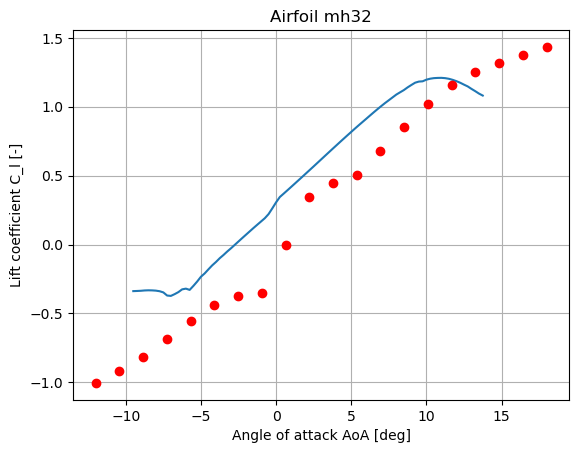

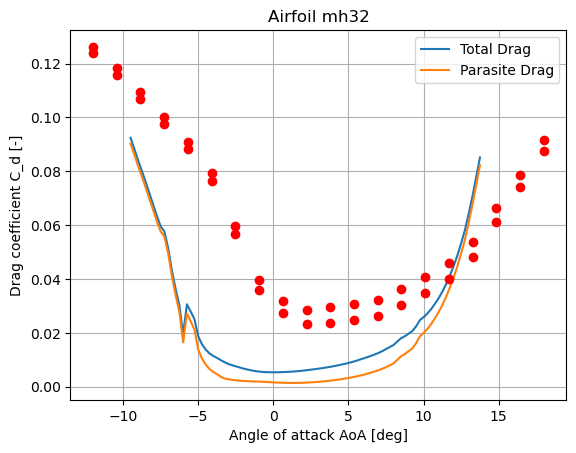

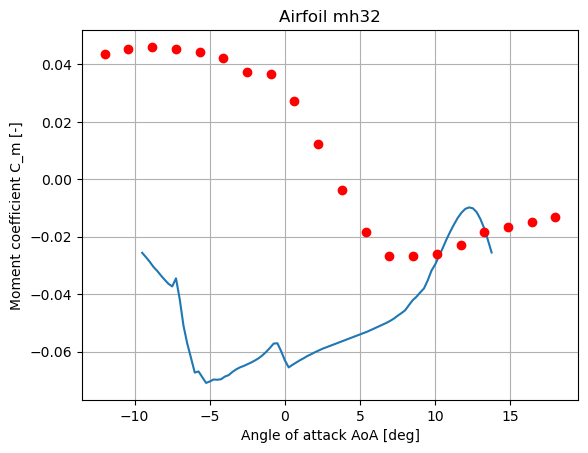

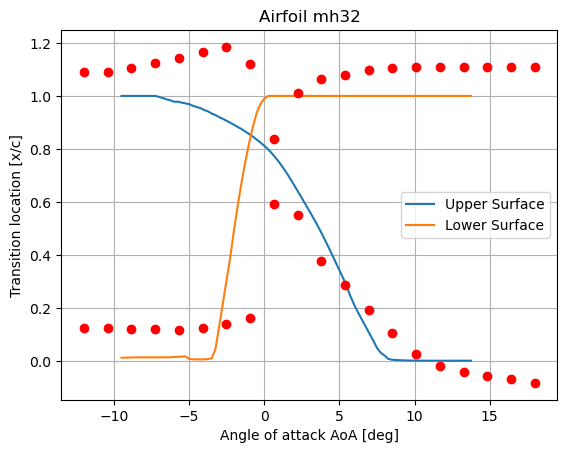

In [18]:
###Plot the prediction
#Lift
plt.plot(alpha, c_l)
for i in range(num_probes):
    plt.plot(alpha_probes[i], pred_c_l[i], marker="o", color="red", label="Predicted")
plt.xlabel("Angle of attack AoA [deg]")
plt.ylabel("Lift coefficient C_l [-]")
plt.title(title)
plt.grid(which="both")
plt.show()

#Drag
plt.plot(alpha, c_d, label="Total Drag")
plt.plot(alpha, c_d_par, label="Parasite Drag")
for i in range(num_probes):
    plt.plot(alpha_probes[i], pred_c_d[i], marker="o", color="red")
    plt.plot(alpha_probes[i], pred_c_d_par[i], marker="o", color="red")
plt.legend()
plt.xlabel("Angle of attack AoA [deg]")
plt.ylabel("Drag coefficient C_d [-]")
plt.title(title)
plt.grid(which="both")
plt.show()
#Moment
plt.plot(alpha, c_m)
for i in range(num_probes):
    plt.plot(alpha_probes[i], pred_c_m[i], marker="o", color="red", label="Predicted")
plt.xlabel("Angle of attack AoA [deg]")
plt.ylabel("Moment coefficient C_m [-]")
plt.title(title)
plt.grid(which="both")
plt.show()
#Transition
plt.plot(alpha, x_tr_t, label="Upper Surface")
plt.plot(alpha, x_tr_b, label="Lower Surface")
for i in range(num_probes):
    plt.plot(alpha_probes[i], pred_x_tr_t[i], marker="o", color="red")
    plt.plot(alpha_probes[i], pred_x_tr_b[i], marker="o", color="red")
plt.legend()
plt.xlabel("Angle of attack AoA [deg]")
plt.ylabel("Transition location [x/c]")
plt.title(title)
plt.grid(which="both")
plt.show()